# Image Processing Walkthrough
This walkthrough is linked to the article "Improving the accuracy of colorimetric detection in paper-based immunosensors with an open-source reader"

##### First we need to import some libraries. We will use the OpenCV library for image processing, numpy for quick matrix calculations, and matplotlib for viewing images in the Jupyter notebook environment.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocessing and Image Capture

##### The code commented-out below shows how our camera object is defined, and how the streaming data is loaded into our matrix object as an image frame.

In [2]:
# Create the in-memory stream
#stream = io.BytesIO()
#with picamera.PiCamera() as camera:
#    camera.start_preview()
#    camera.capture(stream, format='jpeg')

# Construct a numpy array from the stream
#data = np.frombuffer(stream.getvalue(), dtype=np.uint8)

# "Decode" the image from the array, preserving colour
#image = cv2.imdecode(data, 1)

# Convert from OpenCV's BGR format to RGB
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB

# Set the image size to fit the image sensor mode
#image = cv2.resize(image, dsize=(820, 616))

##### The camera captures an image from the streaming buffer when the edges of the paper square "detection area" are recognized. Let's see what an image from the buffer looks like.

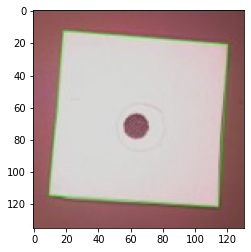

In [3]:
image = cv2.imread("Picture1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

##### To grab the contours of the image, we will split the color channels and use the G channel to look for edges using the Canny edge detector function and the findContours function. Let's do that now and see what edges are found in the image.

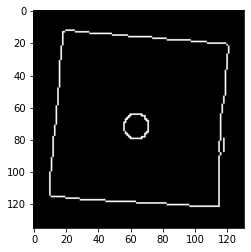

In [4]:
# split the color channels
R,G,B = cv2.split(image)

#copy the G channel
orig = G.copy()

# detect the edges
edges = cv2.Canny(orig, 100, 200)

#find the contour coordinates for the points along the edges
cnts = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#visualize the edges found
edges = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
plt.imshow(edges)

##### Now we can define a few functions that will help us grab the contours in the image buffer, order the coordinate points of four sided objects, and do a four point perspective transform to align the images from a bird's eye view.  Tutorials and licenses for these open-source functions are linked in the article.
##### Let's load these functions now.

In [5]:
# thanks to pyimagesearch.com for these functions 
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

In [6]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [7]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    #valCount = valCount+1
    # return the warped image
    #time.sleep(1)
    return warped

##### With these functions defined , we can now search for the detection area in the image buffer based on a four sided contour. If the square is found, the four point transform function is called, which will order our points and return a bird's eye view of the detection area.

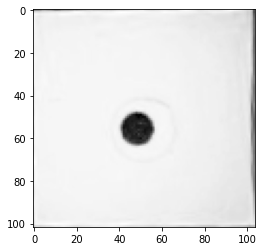

In [8]:
# call the grab_contours function and have it take our contours as its argument
cnts = grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our detection area
    if len(approx) == 4:     
        screenCnt = approx
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
        squareImage = four_point_transform(orig, screenCnt.reshape(4, 2)) 
        #set a boolean to true when the contour has 4 points so we pass it on to the post-processing algorithm later
        isImage = True
        
        if isImage == True:
            #visualize our image so far
            plt.imshow(squareImage, cmap='Greys_r')

##### Now we have an aligned image that is ready for post-processing and quantification.

### Post-Processing and Quantification

##### We start by setting some information about the height and width of the image as variables. define the areas where we will measure the background, average each patch and then store the background average variable.

In [9]:
# set our image size and set as variables
warpedMat = squareImage  
dsize = (500, 500)
densitometerMat = cv2.resize(warpedMat, dsize)
heightCrop =densitometerMat.shape[0]
widthCrop = densitometerMat.shape[1]

# define four 5x5 rectangular patches to measure the background surrounding the signal
patch1 = cv2.getRectSubPix(densitometerMat, (5,5), (100, heightCrop - 100))
patch2 = cv2.getRectSubPix(densitometerMat, (5,5), (widthCrop - 100, 100))
patch3 = cv2.getRectSubPix(densitometerMat, (5,5), (widthCrop - 100, heightCrop - 100))
patch4 = cv2.getRectSubPix(densitometerMat, (5,5), (100, 100))

# average the pixel intensity of the patches
shadow1= np.sum(patch1)/25
shadow2= np.sum(patch2)/25
shadow3= np.sum(patch3)/25
shadow4= np.sum(patch4)/25

# combine the patches to get our background average
backgroundAverage = (shadow1 + shadow2 + shadow3 + shadow4)/4

##### We can visualize the areas being used for the background calculation by marking them with small rectangles. By comparing the results from the 4 sample areas, we can make sure that there are not any shadow artifacts and that the lighting is reasonably even. We can see the average background result by printing the backgroundAverage variable.

patch 1  215.0
patch 2  206.08
patch 3  205.4
patch 4  214.0
background average  210.12


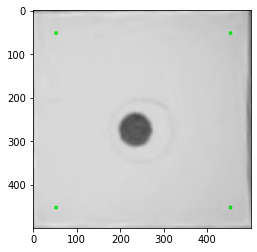

In [10]:
# print averages to compare background patches
print("patch 1 ", shadow1)
print("patch 2 ", shadow2)
print("patch 3 ", shadow3)
print("patch 4 ", shadow4)

# print the final average
print("background average ", backgroundAverage)
densitometerMat = cv2.cvtColor(densitometerMat, cv2.COLOR_BGR2RGB)

# draw some rectangles to visualize the patches on the image
densitometerMat = cv2.rectangle(densitometerMat, (50, 50), (55,55), (0, 225, 0), 2)
densitometerMat = cv2.rectangle(densitometerMat, (450, 50), (455,55), (0, 225, 0), 2)
densitometerMat = cv2.rectangle(densitometerMat, (450, 450), (455,455), (0, 225, 0), 2)
densitometerMat = cv2.rectangle(densitometerMat, (50, 450), (55,455), (0, 225, 0), 2)
plt.imshow(densitometerMat)

##### Time to start making an image mask for our ROI. 
##### First we will duplicate our image and name it "mask", then we will crop both images to the same dimensions.

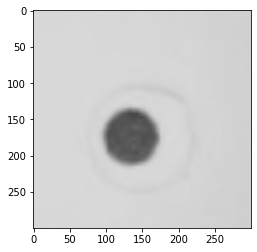

In [11]:
# duplicate the image name it mask
mask = densitometerMat.copy()

# set information about the size of the mask as variables
maskCropHeight =mask.shape[0]
maskCropWidth = mask.shape[1]

# crop the mask and the image to the same dimensions
mask =mask[100:maskCropHeight-100, 100:maskCropWidth-100]    
densitometerMat = densitometerMat[100:maskCropHeight-100, 100:maskCropWidth-100]

# visualize our cropped mask that will be processed into a mask
plt.imshow(mask, cmap='Greys_r')

##### Using the background value from before, we can set a lower boundary for thresholding. The resulting image has the pixels darker than the background set to zero. This is the first step in making the mask.

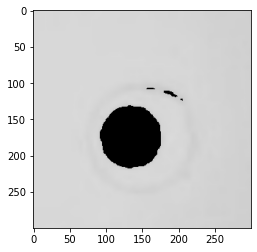

In [12]:
th, thresh = cv2.threshold(densitometerMat,backgroundAverage-8, 255, cv2.THRESH_TOZERO)
plt.imshow(thresh, cmap='Greys_r')

##### Now we will invert the image so that our signal area is white. This is important because when applying a binary mask to another image, the white areas act transparent while the black areas block out the underlying image. 

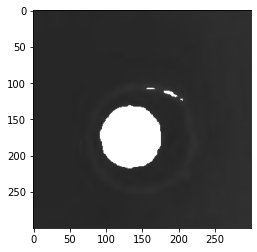

In [13]:
mask = cv2.bitwise_not(thresh)
plt.imshow(mask,cmap='Greys_r')

##### Now that the signal area is white, we can make a binary mask by thresholding anything that is not white to be black.

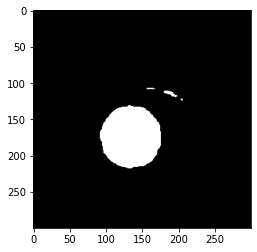

In [14]:
th, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY) 
plt.imshow(mask, cmap='Greys_r')

##### Great, now we have a binary mask. There is an artifact from the background that we can clean up by shrinking the white areas with erosion. First we will define a structuring element to use as a convolutional kernel with the erosion function. After that we will apply the kernel to the image with 15 interations and see the resulting mask.

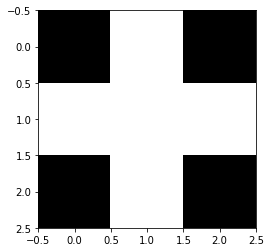

In [15]:
# define a kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# see what the kernel defined above looks like
plt.imshow(kernel, cmap='Greys_r')
# use the kernel to shrink the white areas of the mask with erosion
mask = cv2.erode(mask, kernel, iterations=15)

##### The artifacts from the background are gone after erosion, and so is the majority of the gradient border area between the signal and the background. This is necessary to get consistent measurements regardless of the size of the signal.

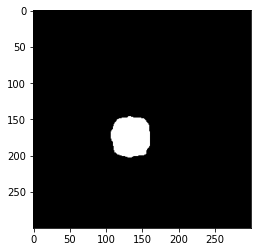

In [16]:
plt.imshow(mask, cmap='Greys_r')

##### Next let's apply the mask to it's unchanged duplicate. The result is an image where signal pixels retain their values and the background area is masked out with black pixels. Since black pixels have a value of zero, we can count the number of pixels that are in the signal using the countNonZero function. Another nice thing about having background pixels masked out with black is that we can sum the matrix image and just get the sum of the signal pixels. With these two pieces of information we can calculate the average pixel density of the signal.

168.21


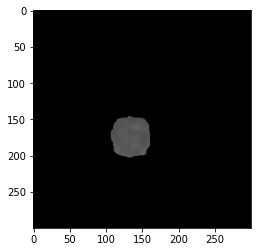

In [17]:
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
densitometerMat = cv2.cvtColor(densitometerMat, cv2.COLOR_BGR2GRAY)

#apply the mask to the other image
final = cv2.bitwise_and(densitometerMat, mask, mask=mask)

#get the number of pixels in the signal
signalPixels = cv2.countNonZero(final)
#divide the sum of the image matrix by the number of pixels in the signal to get the average
signalIntensity = np.sum(final)/signalPixels
# invert to get an result that makes intuitive sense with measuring color signals, i.e. dark signals indicate a
# higher concentration of target analyte, so it is a higher number
signalIntensity = 255-signalIntensity         
signalIntensity = (np.round(signalIntensity,2))
# show the result
print(signalIntensity)
# show the image with the mask applied
final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
plt.imshow(final)